<a href="https://colab.research.google.com/github/MeikoFudo/pet_projects/blob/main/fire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import os
from keras.preprocessing.image import load_img, img_to_array
import os.path
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-01-06 21:07:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.4'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-06 21:07:11 (79.6 MB/s) - 'helper_functions.py.4' saved [10246/10246]



In [ ]:
import os
import pandas as pd
from pathlib import Path

def process_dataset(dataset_path):

    image_dir = Path(dataset_path)
    filepaths = list(image_dir.glob('**/*.JPG')) + list(image_dir.glob('**/*.jpg')) + list(image_dir.glob('**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)

    return dataset_df

def walk_through_dir(dataset_paths):
    all_datasets = pd.DataFrame(columns=['Filepath', 'Label'])

    for dataset_path in dataset_paths:
        print("-" * 90)
        print(f"Processing directory: {dataset_path}")
        dataset_df = process_dataset(dataset_path)
        all_datasets = pd.concat([all_datasets, dataset_df], ignore_index=True)

    return all_datasets

dataset_paths = [
    "../input/fire-dataset/fire_dataset",
    "../input/fire-and-smoke-dataset",
    "../input/forest-fire",
    "../input/test-dataset",
    "../input/house-rooms-streets-image-dataset"
]

final_dataset = walk_through_dir(dataset_paths)
print(final_dataset.info())

------------------------------------------------------------------------------------------
Processing directory: ../input/fire-dataset/fire_dataset
------------------------------------------------------------------------------------------
Processing directory: ../input/fire-and-smoke-dataset
------------------------------------------------------------------------------------------
Processing directory: ../input/forest-fire
------------------------------------------------------------------------------------------
Processing directory: ../input/test-dataset
------------------------------------------------------------------------------------------
Processing directory: ../input/house-rooms-streets-image-dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44723 entries, 0 to 44722
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  44723 non-null  object
 1   Label     44723 non-null  object
dtypes: object(2)
memo

In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44723 entries, 0 to 44722
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  44723 non-null  object
 1   Label     44723 non-null  object
dtypes: object(2)
memory usage: 698.9+ KB


In [ ]:
unique_labels = final_dataset["Label"].unique()
print(unique_labels)

['non_fire_images' 'fire_images' 'smoke' 'fire' 'default' 'train_fire'
 'test_big' 'train-smoke' 'test_small' '0' '1' 'street_data' 'house_data']


In [ ]:
label_mapping = {
    'non_fire_images': 0,
    'fire_images': 1,
    'smoke': 1,
    'fire': 1,
    'default': 0,
    'train_fire': 1,
    'test_big': 1,
    'train-smoke': 1,
    'test_small': 1,
    '0': 0,
    '1': 1,
    'street_data':0,
    'house_data': 0
}

final_dataset["Label"] = final_dataset["Label"].replace(label_mapping)


In [ ]:
final_dataset

,Filepath,Label
0,../input/fire-dataset/fire_dataset/non_fire_im...,0
1,../input/fire-dataset/fire_dataset/non_fire_im...,0
2,../input/fire-dataset/fire_dataset/non_fire_im...,0
3,../input/fire-dataset/fire_dataset/non_fire_im...,0
4,../input/fire-dataset/fire_dataset/non_fire_im...,0
...,...,...
44718,../input/house-rooms-streets-image-dataset/kag...,0
44719,../input/house-rooms-streets-image-dataset/kag...,0
44720,../input/house-rooms-streets-image-dataset/kag...,0
44721,../input/house-rooms-streets-image-dataset/kag...,0


In [ ]:
final_dataset = shuffle(final_dataset.reset_index(drop=True), random_state=42)

In [ ]:
final_dataset

,Filepath,Label
39836,../input/house-rooms-streets-image-dataset/kag...,0
43594,../input/house-rooms-streets-image-dataset/kag...,0
21610,../input/house-rooms-streets-image-dataset/kag...,0
14500,../input/forest-fire/train-smoke/000323.jpg,1
6978,../input/forest-fire/train-smoke/011671.jpg,1
...,...,...
6265,../input/forest-fire/train-smoke/006213.jpg,1
11284,../input/forest-fire/train-smoke/007761.jpg,1
38158,../input/house-rooms-streets-image-dataset/kag...,0
860,../input/fire-dataset/fire_dataset/fire_images...,1


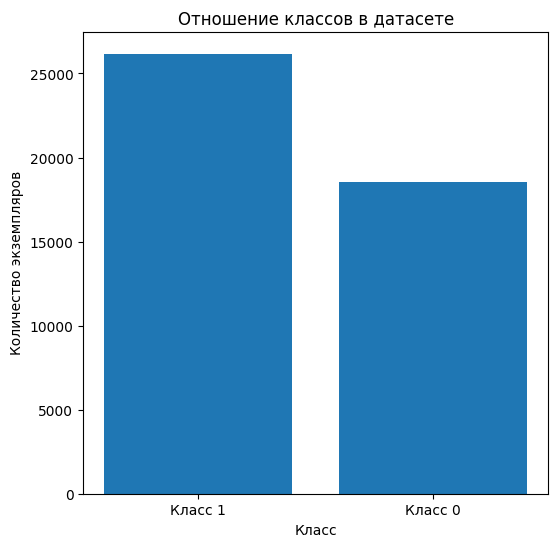

In [ ]:
import matplotlib.pyplot as plt

class_counts = final_dataset['Label'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Класс')
plt.ylabel('Количество экземпляров')
plt.title('Отношение классов в датасете')
plt.xticks(class_counts.index, ['Класс 1', 'Класс 0'])
plt.show()


In [ ]:
unique_labels_new = final_dataset["Label"].unique()
print(unique_labels_new)

[0 1]


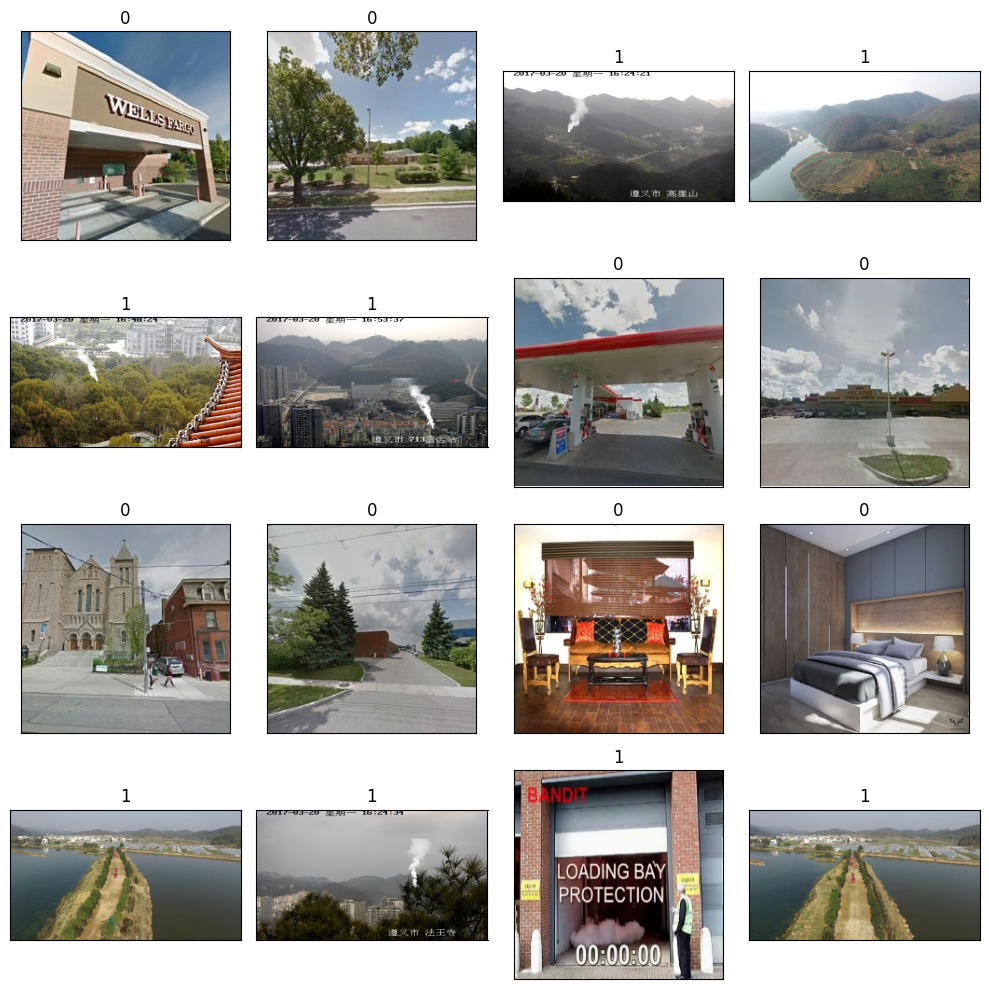

In [ ]:
import matplotlib.image as mpimg
random_index = np.random.randint(0, len(final_dataset), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(final_dataset.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(final_dataset.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(final_dataset, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


Found 28623 validated image filenames.
Found 7155 validated image filenames.
Found 8945 validated image filenames.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [ ]:
import tensorflow as tf

def accuracy(y_true, y_pred):

    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))
    total_samples = tf.cast(tf.size(y_true), tf.float32)
    accuracy_value = correct_predictions / total_samples * 100
    return accuracy_value

def precision(y_true, y_pred, positive_class=1):

    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    predicted_positive = np.sum(np.array(y_pred) == positive_class)

    precision_value = true_positive / predicted_positive if predicted_positive != 0 else 0
    return precision_value

def recall(y_true, y_pred, positive_class=1):

    true_positive = np.sum((np.array(y_true) == positive_class) & (np.array(y_pred) == positive_class))
    actual_positive = np.sum(np.array(y_true) == positive_class)

    recall_value = true_positive / actual_positive if actual_positive != 0 else 0
    return recall_value

def f1_score(y_true, y_pred, positive_class=1):

    precision_value = precision(y_true, y_pred, positive_class)
    recall_value = recall(y_true, y_pred, positive_class)

    f1_score_value = 2 * (precision_value * recall_value) / (precision_value + recall_value) if (precision_value + recall_value) != 0 else 0
    return f1_score_value

In [ ]:
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=[accuracy]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "fire_classification"),
        checkpoint_callback,
    ]
)

if early_stopping.stopped_epoch > 0:
    print("Training finished early due to early stopping.")
else:
    print("Training completed all epochs.")


Saving TensorBoard log files to: training_logs/fire_classification/20240106-211722
Epoch 1/100
895/895 [==============================] - 336s 369ms/step - loss: 0.0558 - accuracy: 98.1215 - val_loss: 0.0225 - val_accuracy: 99.2606
Epoch 2/100
895/895 [==============================] - 172s 192ms/step - loss: 0.0194 - accuracy: 99.2877 - val_loss: 0.0178 - val_accuracy: 99.4185
Epoch 3/100
895/895 [==============================] - 172s 192ms/step - loss: 0.0107 - accuracy: 99.6962 - val_loss: 0.0167 - val_accuracy: 99.4699
Epoch 4/100
895/895 [==============================] - 173s 193ms/step - loss: 0.0078 - accuracy: 99.7591 - val_loss: 0.0136 - val_accuracy: 99.5815
Epoch 5/100
895/895 [==============================] - 169s 189ms/step - loss: 0.0049 - accuracy: 99.8394 - val_loss: 0.0144 - val_accuracy: 99.5675
Epoch 6/100
895/895 [==============================] - 171s 191ms/step - loss: 0.0049 - accuracy: 99.8389 - val_loss: 0.0203 - val_accuracy: 99.3862
Epoch 7/100
895/895 [==

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_predictions = model.predict(test_images)
test_labels = test_df['Label'].values

binary_predictions = np.round(test_predictions).flatten()

print("Classification Report:")
print(classification_report(test_labels, binary_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, binary_predictions))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")


280/280 [==============================] - 97s 346ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5208
           1       0.99      1.00      0.99      3737

    accuracy                           0.99      8945
   macro avg       0.99      0.99      0.99      8945
weighted avg       0.99      0.99      0.99      8945


Confusion Matrix:
[[5169   39]
 [  18 3719]]

Metrics:
Accuracy: 99.36%
Precision: 0.99
Recall: 1.00
F1-Score: 0.99


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


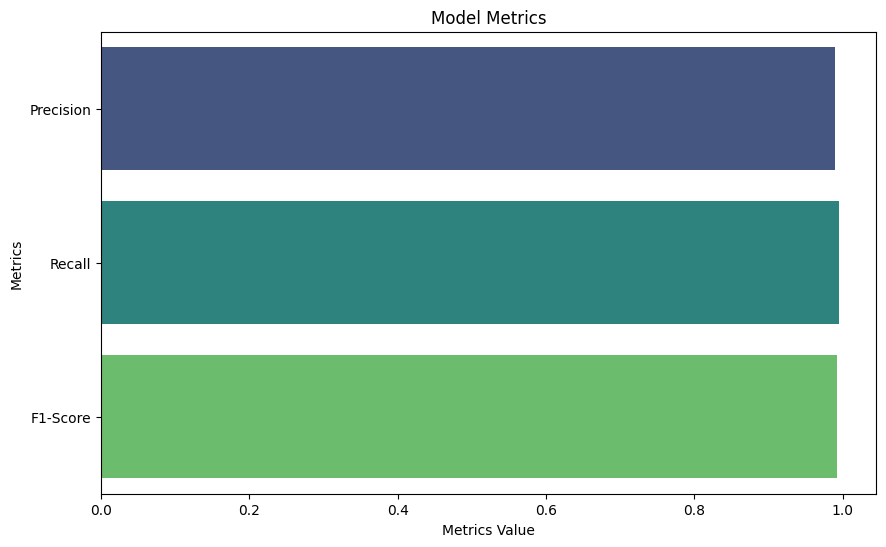

In [ ]:
metrics_names = ['Precision', 'Recall', 'F1-Score']
metrics_values = [precision_value, recall_value, f1_score_value]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_values, y=metrics_names, palette="viridis")
plt.title("Model Metrics")
plt.xlabel("Metrics Value")
plt.ylabel("Metrics")
plt.show()

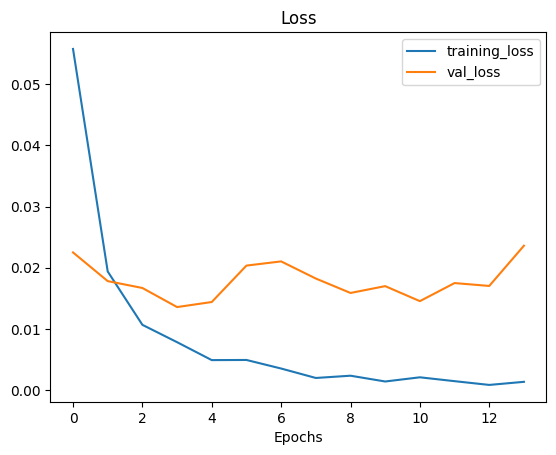

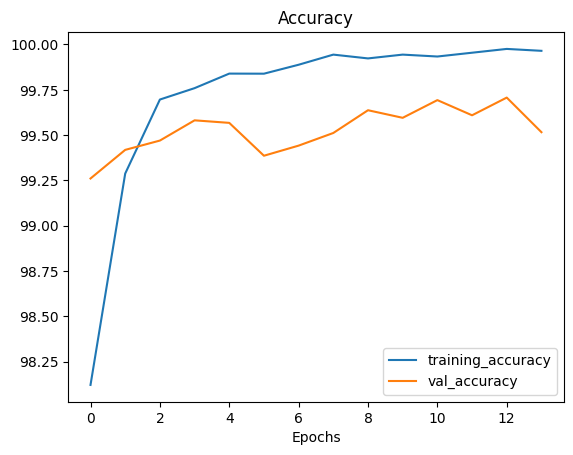

In [ ]:
plot_loss_curves(history)

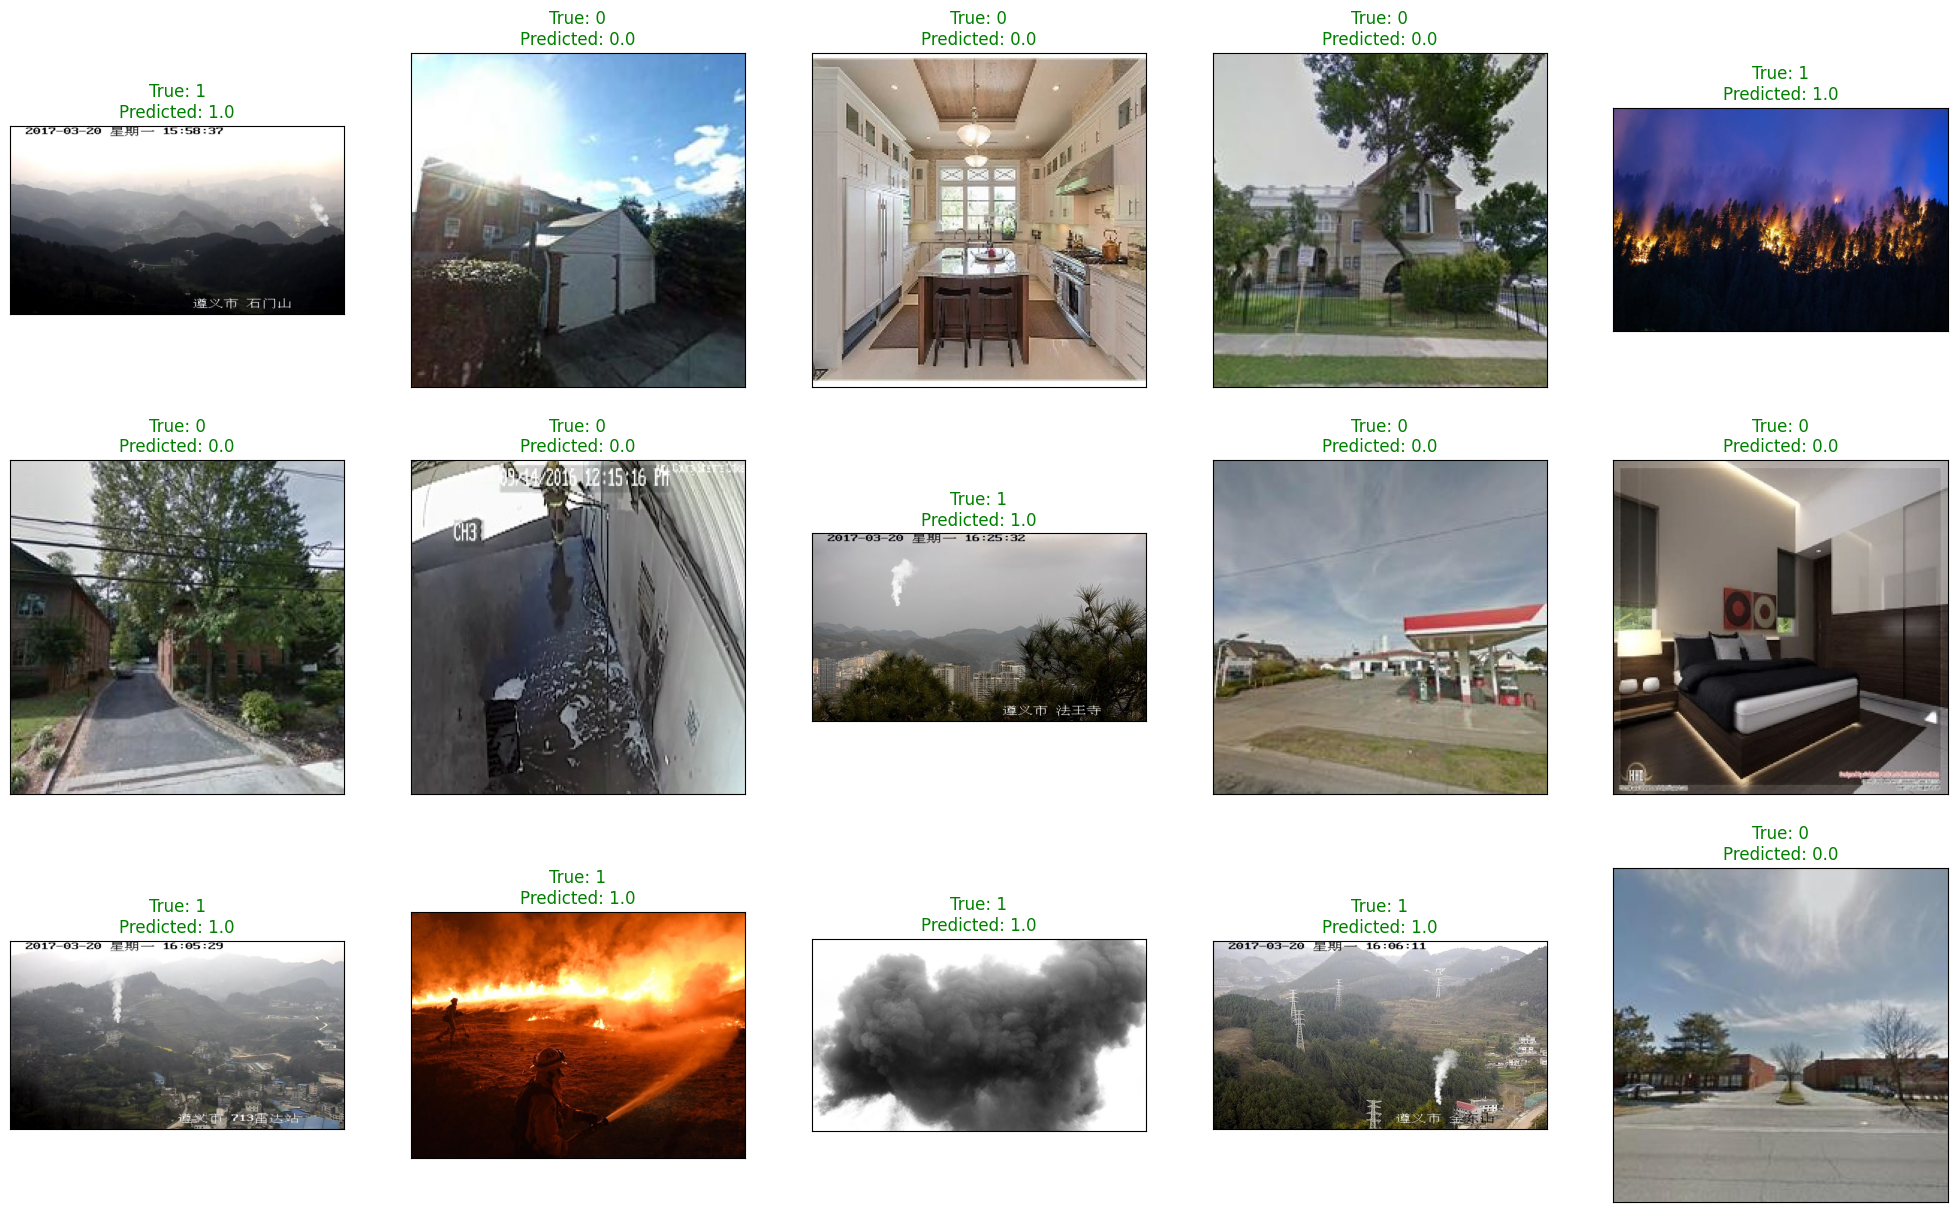

<Figure size 640x480 with 0 Axes>

In [ ]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)

    if test_labels[random_index[i]] == binary_predictions[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_labels[random_index[i]]}\nPredicted: {binary_predictions[random_index[i]]}", color=color)

plt.show()
plt.tight_layout()
